# Setup

## Download the repo

In [1]:
# !git clone https://github.com/YuanGongND/ssast.git
!git clone https://github.com/roeizig/ssast.git

Cloning into 'ssast'...
remote: Enumerating objects: 7820, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 7820 (delta 127), reused 144 (delta 67), pack-reused 7556
Receiving objects: 100% (7820/7820), 792.26 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (622/622), done.
Checking out files: 100% (8722/8722), done.


## Install requirements

In [2]:
!cd ssast/
!pip install -r /content/ssast/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 78.8 MB/s 
     |████████████████████████████████| 13.1 MB 35.6 MB/s 
     |████████████████████████████████| 3.4 MB 65.6 MB/s 
     |████████████████████████████████| 15.3 MB 80.9 MB/s 
     |████████████████████████████████| 22.3 MB 26.3 MB/s 
     |████████████████████████████████| 28.5 MB 278 kB/s 
     |████████████████████████████████| 287 kB 81.7 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
     |████████████████████████████████| 1.9 MB 21.7 MB/s 
     |████████████████████████████████| 19.1 MB 57.3 MB/s 
     |████████████████████████████████| 19.1 MB 62.6 MB/s 
     |████████████████████████████████| 21.0 MB 317 kB/s 
     |████████████████████████████████| 23.2 MB 190 kB/s 
     |████████████████████████████████| 23.3 MB 666 kB/s 
     |████████████████████████████████| 23.3 MB 1.1 MB/s 
     |██████████████████

## Imports

In [1]:
import torch
import torchaudio
from PIL import Image
import numpy as np
from ssast.src.models.ast_models import *
from tqdm.notebook import tqdm_notebook
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import output
output.enable_custom_widget_manager()

# output.disable_custom_widget_manager()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Overriding the model

## New model definition

In [2]:
from ssast.src.models.ast_models import ASTModel

class ASTModelRoei(ASTModel):
    def __init__(self):
      super().__init__(fshape=16, tshape=16, fstride=10, tstride=10, 
                      input_fdim=128, input_tdim=1024, model_size='tiny', 
                      pretrain_stage=False, load_pretrained_mdl_path='/content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth')
      # regressor head for fine-tuning / inference
      # self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
      #                               nn.Linear(self.original_embedding_dim, 1))
      self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                    nn.Linear(self.original_embedding_dim, 1))


    def finetuning_regressor(self, x, y, loss_method = 'L1'):
        # Finetuning using the regressor task.
        # Calculate MSE loss and update weights accordingly
        # B = x.shape[0]

        # Calculate RMSE loss and update weights
        pred = self.regressor(x)
        target = y
        # If cannot use reference in a vectorized manner, use the for loop below
        # pred = torch.empty((B), device=x.device).float()  # e.g. size 12 for a batch of 12 spectrograms
        # target = torch.empty((B), device=x.device).float() # e.g. size 12 for a batch of 12 spectrograms
        # for i in range(B):
        #     #  +2 for indexes because of cls and dis token
        #     pred[i] = self.regressor(x[i])
        #     target[i] = y[i]
        # calculate the RMSE loss
        # rmse = torch.mean((pred - target) ** 2)**0.5

        # Update weights according to MSE loss
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        optimizer.zero_grad()
        criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        return loss


    def regressor(self, x):
        # Copied from "finetuningavgtok"
        # changed only the last part, sending the intermediate result
        # to the regressor head instead of the mlp head.
        # Inference only mode
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.regressor_head(x)
        return x


    def forward(self, x, task = 'regressor', y=None, cluster=True, mask_patch=400, loss_method = 'L1'):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # fine tuning the model as a regressor
        elif task == 'ft_regressor':
            return self.finetuning_regressor(x, y, loss_method)
        # inference using a regressor
        elif task == 'regressor':
            return self.regressor(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        else:
            raise Exception('Task unrecognized.')



## Creating the overridden model

In [3]:
# new_model = ASTModelRoei()
# new_model.eval()
# new_model.to(device)

## Creating the dataset

In [4]:
## Creating Dataset
from random import sample
from torch.utils.data import Dataset, DataLoader
import os
import math
from torchvision import transforms


class SpectrogramData(Dataset):
    
    def __init__(self, audio_dir, device):
        self.audio_dir = audio_dir
        self.device = device
        self._create_ann()
        self.transform = transforms.PILToTensor()

        
    def __len__(self):
        return len(self.annotations[0])
        

    def __getitem__(self, index):
        sample_path = self._get_sample_path(index)
        label = float(self._get_sample_label(index))

        signal = Image.open(sample_path)
        signal = self.transform(signal)
        signal = signal.to(self.device, dtype=torch.float)
        return signal, label, index

            
    def _create_ann(self, path="ssast/spectrogram_images_V3a/"):
        Ann = [[],[],[]]
        for subdir, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('png'):
                                Ann[0].append(file) ##name
                                Ann[1].append(subdir) #folder
                                tmp_label = file.split('_')[-1]
                                Ann[2].append(float(tmp_label[:-4])) #label
        Ann = np.asarray(Ann)
        self.annotations = Ann


    def shuffle(self):
      perm = torch.randperm(len(self.annotations[0]))
      self.annotations= self.annotations[:,perm]
      pass    
    

    def _get_sample_path(self, index):
        folder = self.annotations[1][index]
        filename = self.annotations[0][index]
        path = os.path.join(self.audio_dir, folder, filename)
        return path
    

    def _get_sample_label(self, index):
        label = self.annotations[2][index]
        return label

##Functuins for DataViz
    def _index_from_label(self, query_label):
        labels =[float(x) for x in self.annotations[2]]
        query_label = np.asarray(query_label)
        diff = (np.abs(labels-query_label))
        # index = diff.argmin()
        index = np.where(diff == diff.min())
        # print(np.where(diff == diff.min()))
        # print(index)
        return index
        
    def seq_from_label(self, query, query_type = 'label'):
        
        if query_type == 'label':
          index = self._index_from_label(query)
          # print(index[0][0])
          index = index[0][0]
        else:
          index = query
        folder = self.annotations[1][index]
        current_call_filename = self.annotations[0][index]
        
        current_call_path = self._get_sample_path(index)
        current_call =Image.open(current_call_path)
        
        current_call_num = int(current_call_filename.split('_')[-3])
        prefix = '_'.join(current_call_filename.split('_')[:-3])

        next_call_prefix = '_'.join([prefix, str(current_call_num+1)])+'_'
        prev_call_prefix = '_'.join([prefix, str(current_call_num-1)])+'_'
        
      
        next_call_filename= None
        prev_call_filename = None
        next_call = None
        prev_call = None
      
        for subdir, dirs, files in os.walk(folder):
          for file in files:
              if file.startswith(bytes(next_call_prefix,'utf-8')):
                              next_call_filename = file.decode()
                              next_call_path = os.path.join(folder, next_call_filename)
                              next_call = Image.open(next_call_path)
              if file.startswith(bytes(prev_call_prefix,'utf-8')):
                              prev_call_filename = file.decode()
                              prev_call_path = os.path.join(folder, prev_call_filename)
                              prev_call = Image.open(prev_call_path)
        
        images = [prev_call, current_call, next_call]
        names  = [prev_call_filename, current_call_filename, next_call_filename]

        for i, (img,name) in enumerate(zip(images, names)):
          if img:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            plt.imshow(img, origin = 'lower')
            plt.title(name)
            plt.show()
          else:
            if i == 0:
              print(f'previous call does not exist')
            else:
              print(f'next call does not exist')

        return images, names




In [5]:
path = "ssast/spectrogram_images_V3a/"
x = SpectrogramData("", device)
print(len(x))
trainval , testset = torch.utils.data.random_split(x, [1900, len(x)-1900],
                                            generator=torch.Generator().manual_seed(42))
trainset, valset = torch.utils.data.random_split(trainval, [1500, 400],
                                                generator=torch.Generator().manual_seed(42))

2034


In [6]:
# ##Testing the sequence display
# label = 52.2493
# # label = 60
# images, names = x.seq_from_label(label)

## Testing the model on a single spectrogram

In [7]:
# xx = x[1]
# pred = new_model(xx[0], task='regressor')
# label = xx[-1]
# print(pred)
# print(label)

In [8]:
# new_model(spectgram.unsqueeze(0).to(dtype=torch.float), task='ft_regressor', y=torch.Tensor([[float(xx[-1])]]))

# Training the Model

In [13]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [ ]:
# torch.cuda.empty_cache()

In [14]:
def train_loop(trainloader, valloader, model, epochs = 30, loss_method = 'L2'):
  model = model.to(device)
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  for e in range(epochs):
      running_loss = 0
      train_correct = 0
      model.train()
      for images, labels,_ in tqdm_notebook(trainloader):

          images = images.to(device, dtype=torch.float)
          labels = labels.to(device, dtype=torch.float)
          loss = model(images.squeeze(1), task='ft_regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
          loss = loss.item()
          
          # print(loss)
          running_loss += loss
          # ##evaluating without dropout
          # with torch.no_grad():
          #   model.eval()
          #   logits = model(images.to(device))
          #   ps = torch.softmax(logits,dim=1)
          #   top_ps, top_class = ps.topk(1,dim=1)
          #   train_equals_batch = top_class == (labels.view(*top_class.shape))
          #   train_correct +=train_equals_batch.sum().item()
          
          # model.train()
          
          
      else:
          running_val_loss = 0
          val_correct = 0
          
          with torch.no_grad():
              model.eval()
              for images, labels,_ in tqdm_notebook(valloader):  
                  images = images.to(device, dtype=torch.float)
                  labels = labels.to(device, dtype=torch.float)
                  pred = model(images.squeeze(1), task='regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
                  criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
                  loss = criterion(pred, labels.unsqueeze(-1).to(device, dtype = float))
                  loss = loss.item()
                  running_val_loss += loss

                  # ps = torch.softmax(logits, dim=1)
                  # top_ps, top_class = ps.topk(1,dim=1)
                  # equals_batch = top_class == labels.view(*top_class.shape)
                  # test_correct +=equals_batch.sum().item()
              model.train()
          
          training_loss = running_loss/len(trainloader)
          val_loss = running_val_loss/len(valloader)
          train_accuracy = 0 # train_correct/len(trainloader.dataset)
          val_accuracy = 0 #test_correct/len(testloader.dataset)
          if e>0:
            if val_loss<min(val_losses):
              print('saving model...')
              torch.save(model.state_dict(),'model.pth')

          
          train_losses.append(training_loss)
          val_losses.append(val_loss)
          train_accs.append(train_accuracy)
          val_accs.append(val_accuracy)
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(training_loss),
                "Test Loss: {:.3f}.. ".format(val_loss))
  return train_losses, train_accs, val_losses, val_accs  

In [15]:
new_model = ASTModelRoei()
new_model.to(device)
trainloss,trainacc,valloss,valacc = train_loop(trainloader, valloader, model = new_model, epochs = 100, loss_method = 'L2')


now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


  0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1/100..  Training Loss: 1297.011..  Test Loss: 561.887.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 2/100..  Training Loss: 178.782..  Test Loss: 25.532.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 3/100..  Training Loss: 14.915..  Test Loss: 18.982.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 4/100..  Training Loss: 11.155..  Test Loss: 10.201.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 5/100..  Training Loss: 9.214..  Test Loss: 9.150.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6/100..  Training Loss: 7.835..  Test Loss: 20.549.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 7/100..  Training Loss: 8.129..  Test Loss: 7.416.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 8/100..  Training Loss: 7.093..  Test Loss: 5.855.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 9/100..  Training Loss: 7.183..  Test Loss: 5.658.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10/100..  Training Loss: 6.179..  Test Loss: 12.788.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11/100..  Training Loss: 5.685..  Test Loss: 8.265.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 12/100..  Training Loss: 6.247..  Test Loss: 5.597.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 13/100..  Training Loss: 5.573..  Test Loss: 5.437.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14/100..  Training Loss: 6.799..  Test Loss: 5.864.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15/100..  Training Loss: 6.035..  Test Loss: 7.090.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16/100..  Training Loss: 5.663..  Test Loss: 5.977.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17/100..  Training Loss: 5.895..  Test Loss: 6.057.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18/100..  Training Loss: 5.750..  Test Loss: 6.352.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19/100..  Training Loss: 5.370..  Test Loss: 5.751.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 20/100..  Training Loss: 5.411..  Test Loss: 5.176.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21/100..  Training Loss: 5.614..  Test Loss: 5.569.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22/100..  Training Loss: 5.081..  Test Loss: 5.574.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23/100..  Training Loss: 4.896..  Test Loss: 5.443.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24/100..  Training Loss: 4.979..  Test Loss: 5.354.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25/100..  Training Loss: 5.051..  Test Loss: 15.096.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26/100..  Training Loss: 4.708..  Test Loss: 5.469.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27/100..  Training Loss: 4.251..  Test Loss: 5.542.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 28/100..  Training Loss: 4.525..  Test Loss: 6.136.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29/100..  Training Loss: 4.753..  Test Loss: 6.568.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 30/100..  Training Loss: 4.265..  Test Loss: 5.475.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 31/100..  Training Loss: 4.446..  Test Loss: 5.062.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 32/100..  Training Loss: 4.175..  Test Loss: 5.653.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 33/100..  Training Loss: 5.357..  Test Loss: 4.779.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 34/100..  Training Loss: 3.888..  Test Loss: 14.537.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 35/100..  Training Loss: 4.088..  Test Loss: 5.535.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 36/100..  Training Loss: 4.788..  Test Loss: 5.450.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 37/100..  Training Loss: 4.808..  Test Loss: 6.152.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 38/100..  Training Loss: 4.480..  Test Loss: 8.442.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 39/100..  Training Loss: 4.212..  Test Loss: 5.830.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 40/100..  Training Loss: 4.119..  Test Loss: 4.744.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 41/100..  Training Loss: 4.051..  Test Loss: 7.312.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 42/100..  Training Loss: 3.826..  Test Loss: 6.078.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 43/100..  Training Loss: 3.609..  Test Loss: 4.862.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 44/100..  Training Loss: 4.239..  Test Loss: 5.082.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 45/100..  Training Loss: 3.848..  Test Loss: 5.127.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 46/100..  Training Loss: 3.902..  Test Loss: 5.754.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 47/100..  Training Loss: 4.086..  Test Loss: 4.928.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 48/100..  Training Loss: 4.029..  Test Loss: 4.445.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 49/100..  Training Loss: 4.350..  Test Loss: 4.527.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 50/100..  Training Loss: 4.598..  Test Loss: 5.182.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 51/100..  Training Loss: 3.724..  Test Loss: 4.792.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 52/100..  Training Loss: 3.521..  Test Loss: 4.726.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 53/100..  Training Loss: 4.004..  Test Loss: 6.749.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 54/100..  Training Loss: 3.781..  Test Loss: 6.204.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 55/100..  Training Loss: 3.503..  Test Loss: 4.128.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 56/100..  Training Loss: 3.570..  Test Loss: 3.897.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 57/100..  Training Loss: 3.262..  Test Loss: 5.303.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 58/100..  Training Loss: 3.563..  Test Loss: 3.808.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 59/100..  Training Loss: 3.244..  Test Loss: 5.641.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 60/100..  Training Loss: 3.250..  Test Loss: 4.933.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 61/100..  Training Loss: 3.165..  Test Loss: 5.070.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 62/100..  Training Loss: 3.296..  Test Loss: 6.067.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 63/100..  Training Loss: 3.209..  Test Loss: 4.568.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 64/100..  Training Loss: 3.269..  Test Loss: 5.113.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 65/100..  Training Loss: 3.259..  Test Loss: 4.845.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 66/100..  Training Loss: 3.008..  Test Loss: 3.849.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 67/100..  Training Loss: 2.966..  Test Loss: 4.751.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 68/100..  Training Loss: 3.067..  Test Loss: 3.910.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 69/100..  Training Loss: 3.084..  Test Loss: 5.914.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 70/100..  Training Loss: 3.512..  Test Loss: 6.179.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 71/100..  Training Loss: 3.169..  Test Loss: 4.706.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 72/100..  Training Loss: 2.944..  Test Loss: 5.677.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 73/100..  Training Loss: 3.001..  Test Loss: 3.654.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 74/100..  Training Loss: 2.871..  Test Loss: 4.328.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 75/100..  Training Loss: 2.825..  Test Loss: 4.691.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 76/100..  Training Loss: 2.746..  Test Loss: 4.543.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 77/100..  Training Loss: 2.606..  Test Loss: 4.762.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 78/100..  Training Loss: 3.091..  Test Loss: 4.812.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 79/100..  Training Loss: 2.630..  Test Loss: 4.220.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 80/100..  Training Loss: 2.882..  Test Loss: 5.868.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 81/100..  Training Loss: 3.879..  Test Loss: 4.258.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 82/100..  Training Loss: 2.962..  Test Loss: 3.980.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 83/100..  Training Loss: 2.654..  Test Loss: 4.941.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 84/100..  Training Loss: 2.641..  Test Loss: 4.680.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 85/100..  Training Loss: 2.824..  Test Loss: 4.776.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 86/100..  Training Loss: 2.662..  Test Loss: 4.221.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 87/100..  Training Loss: 2.949..  Test Loss: 4.737.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 88/100..  Training Loss: 2.937..  Test Loss: 4.027.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 89/100..  Training Loss: 2.626..  Test Loss: 5.969.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 90/100..  Training Loss: 2.633..  Test Loss: 4.933.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 91/100..  Training Loss: 2.824..  Test Loss: 3.757.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 92/100..  Training Loss: 2.691..  Test Loss: 4.071.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 93/100..  Training Loss: 2.592..  Test Loss: 4.722.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 94/100..  Training Loss: 2.972..  Test Loss: 4.290.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 95/100..  Training Loss: 2.510..  Test Loss: 6.087.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 96/100..  Training Loss: 2.763..  Test Loss: 4.023.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 97/100..  Training Loss: 2.408..  Test Loss: 3.904.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 98/100..  Training Loss: 2.949..  Test Loss: 4.696.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 99/100..  Training Loss: 2.623..  Test Loss: 5.188.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 100/100..  Training Loss: 2.495..  Test Loss: 4.984.. 


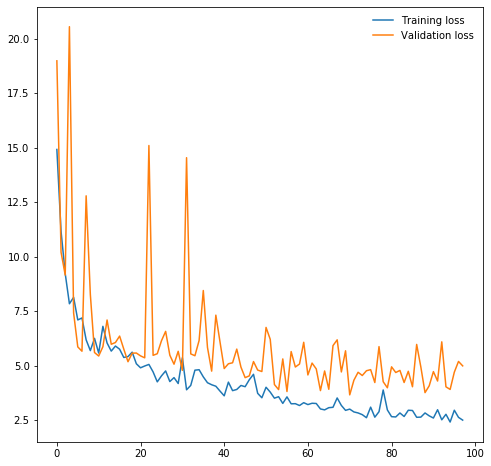

In [16]:
plt.figure(figsize = (8,8))
plt.plot(trainloss[2:],label = 'Training loss')
plt.plot(valloss[2:],label = 'Validation loss')
plt.legend(frameon=False)


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
# Save the model itself
# torch.save(new_model, 'model_30e_clean.pth')

# Save the model's weights
torch.save(new_model.state_dict(), 'model_weights_100e_V3.pth')

In [ ]:
# plt.figure(figsize = (8,8))
# plt.plot(trainloss,label = 'Training loss')
# plt.plot(valloss,label = 'Validation loss')
# plt.legend(frameon=False)

# # plt.figure(figsize = (8,8))
# # plt.plot(train_accs_d,label = 'Training Accuracy')
# # plt.plot(test_accs_d,label = 'Validation Accuracy')
# # plt.legend(frameon=False)

# Load an existing model

In [9]:
new_model = ASTModelRoei()
# new_model.load_state_dict(torch.load('/content/ssast/pretrained_model/model_weights_84e_L2_early_stop.pth'))
new_model.load_state_dict(torch.load('model.pth'))
new_model.eval()
new_model.to(device)

now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ASTModelRoei(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((19

# Analyze results

## Functions

In [18]:
def get_sample_results(model, dataset):
    data_size = len(dataset.indices)
    if data_size < 256:
        dataloader = DataLoader(dataset, batch_size=data_size,
                                shuffle=True, num_workers=0)
        images, labels, index = next(iter(dataloader))
        with torch.no_grad():
            model.eval()
            preds = model(images.squeeze(1).to(device, dtype=torch.float), task='regressor')
            diff = preds.squeeze().cpu() - labels.squeeze().cpu()
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    else:
        batch_size = 256
        dataloader = DataLoader(dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
        labels = torch.tensor((), device=device)
        preds = torch.tensor((), device=device)
        diff = torch.tensor(())
        index = torch.tensor(())
        with torch.no_grad():
            model.eval()
            for batch_images, batch_labels, batch_index in dataloader:
                batch_images = batch_images.to(device, dtype=torch.float)
                batch_labels = batch_labels.to(device, dtype=torch.float)
                batch_preds = model(batch_images.squeeze(1), task='regressor')
                batch_diff = batch_preds.squeeze().cpu() - batch_labels.squeeze().cpu()
                labels = torch.cat([labels, batch_labels], dim=0)
                preds = torch.cat([preds, batch_preds], dim=0)
                diff = torch.cat([diff, batch_diff], dim=0)
                index = torch.cat([index, batch_index], dim=0)
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    print(f"Dataset RMSE is {rmse:.2f}")
    return pd.DataFrame({'pred': preds.cpu().squeeze(), 
                         'label': labels.cpu().squeeze(), 
                         'diff' :diff, 
                         'abs_diff': diff.abs(),
                         'index' : index})

In [19]:
def analyze_sample_results(stats_df):
    # Scatter plot with linear trend y=x
    lin_min = np.min([stats_df['pred'].min(), stats_df['label'].min()])
    lin_max = np.max([stats_df['pred'].max(), stats_df['label'].max()])
    plt.figure(figsize=(15, 9))
    plt.scatter(stats_df['label'], stats_df['pred'])
    plt.plot([lin_min, lin_max], [lin_min, lin_max], color='red')
    plt.title("Model prediction vs. label", size=18)
    plt.xlabel("Label", size=16)
    plt.ylabel("Prediction", size=16)
    plt.show()

    # Error histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['diff'], bins=100)
    plt.title("Model's error distribution", size=18)
    plt.xlabel("Error", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()


    # label histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['label'], bins=100)
    plt.title("GT distribution", size=18)
    plt.xlabel("label", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()

    # Diff statistics
    display(stats_df.describe([.1, .25, .5, .75, .9])[['abs_diff']].T)

## Test analysis

Dataset RMSE is 1.88


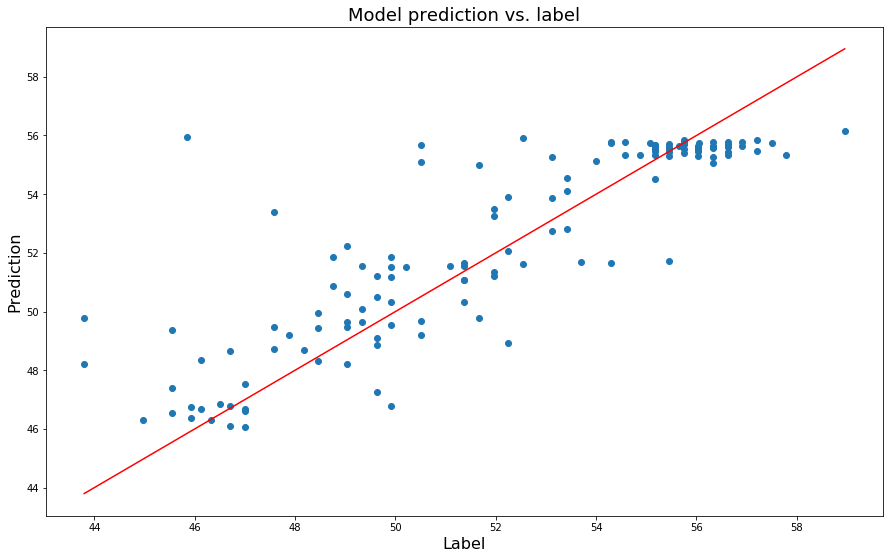

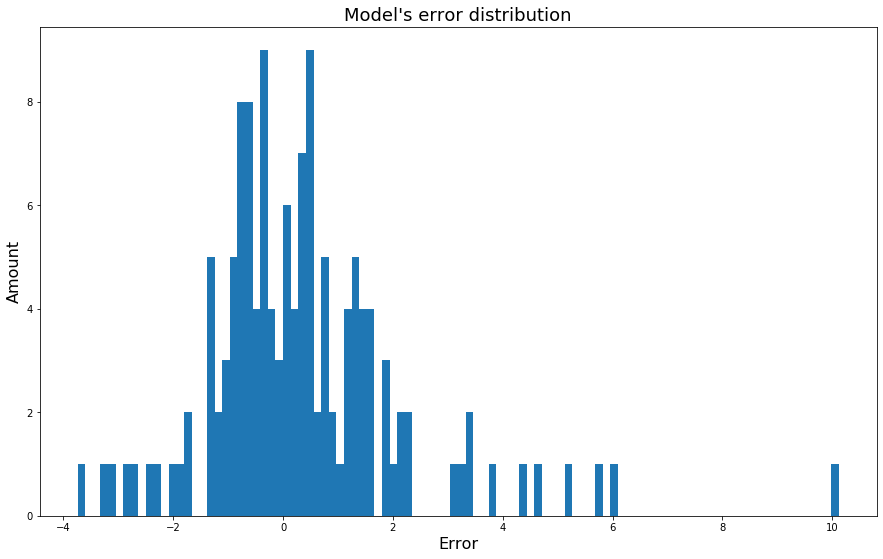

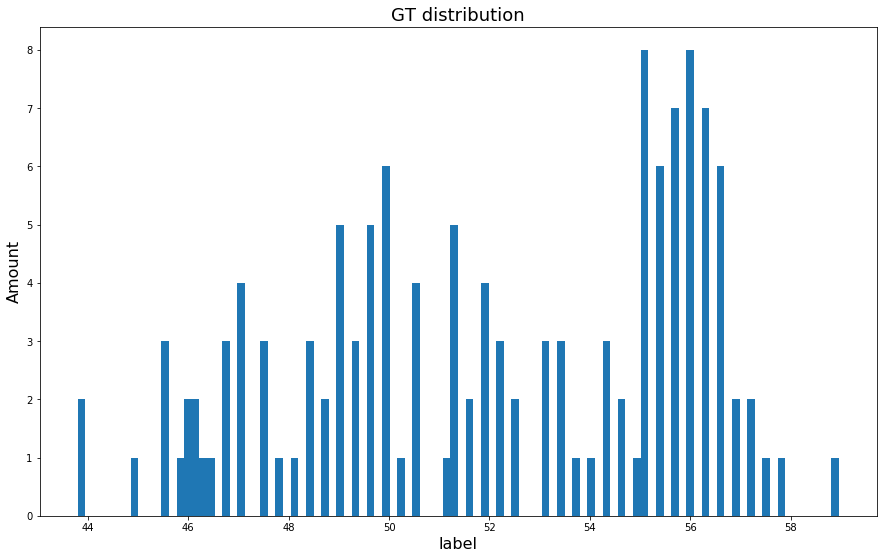

count      mean       std       min       10%       25%       50%  \
abs_diff  134.0  1.267042  1.399992  0.001099  0.188181  0.424614  0.813926   

               75%       90%        max  
abs_diff  1.550076  3.005603  10.114037

In [20]:
test_df = get_sample_results(new_model, testset)
analyze_sample_results(test_df)
torch.cuda.empty_cache()

## Train & Validation analysis

Dataset RMSE is 1.55


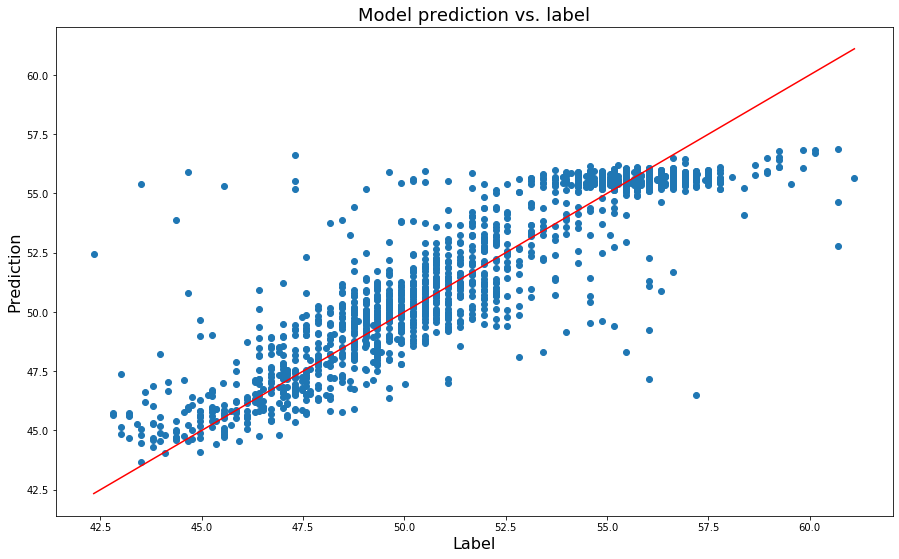

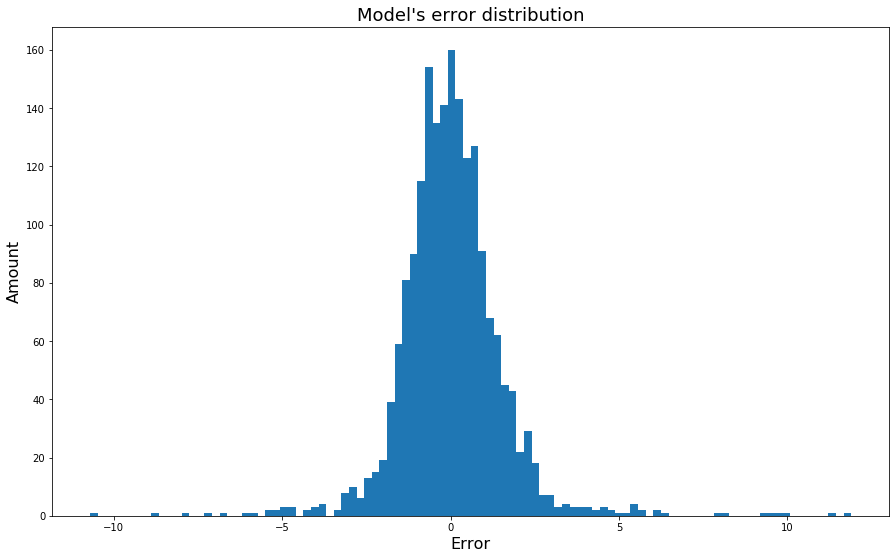

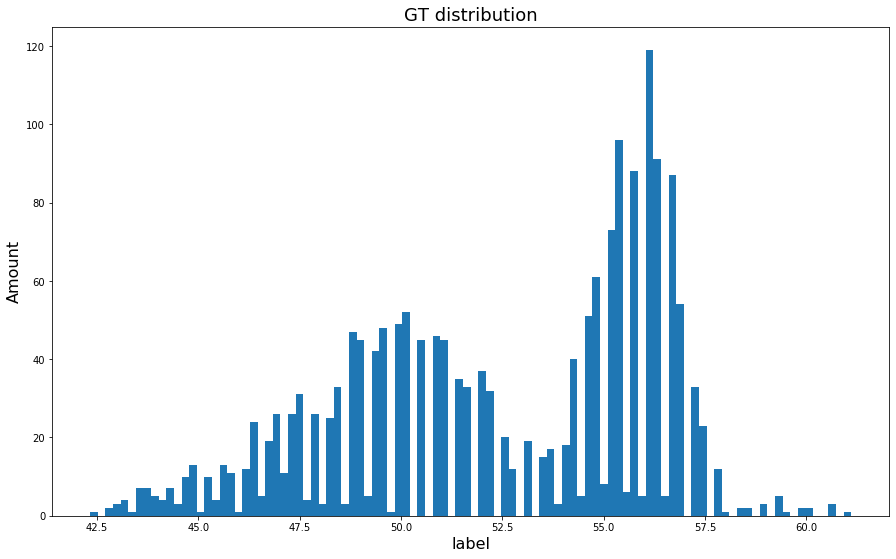

count      mean      std       min       10%       25%      50%  \
abs_diff  1900.0  1.047334  1.14661  0.000999  0.128941  0.358104  0.76157   

               75%       90%        max  
abs_diff  1.362415  2.094244  11.898308

In [21]:
trainval_df = get_sample_results(new_model, trainval)
analyze_sample_results(trainval_df)
torch.cuda.empty_cache()

## Find samples of largest error

 Search "label_{label}" in images folder for the actual image

In [22]:
(pd.concat([trainval_df,
           test_df],
          axis=0)
.sort_values('abs_diff', ascending=False).head(10))

pred      label       diff   abs_diff   index
1060  55.401207  43.502899  11.898308  11.898308  1600.0
1263  55.903244  44.669102  11.234142  11.234142  1305.0
756   46.503643  57.205502 -10.701859  10.701859   334.0
23    55.949337  45.835300  10.114037  10.114037  1606.0
1659  52.426872  42.336700  10.090172  10.090172   586.0
305   55.327499  45.538898   9.788601   9.788601  1254.0
94    53.860119  44.377602   9.482517   9.482517   591.0
1674  56.610619  47.292999   9.317619   9.317619  1042.0
198   47.165840  56.044701  -8.878860   8.878860  1267.0
760   55.528652  47.292999   8.235653   8.235653   732.0

# Display sequences of largest errors


Error of 11.90
Pred: 55.40
3-Sequence of the respective images:
previous call does not exist


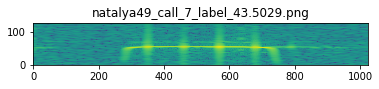

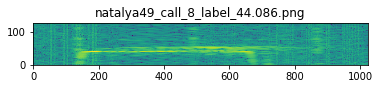


Error of 11.23
Pred: 55.90
3-Sequence of the respective images:


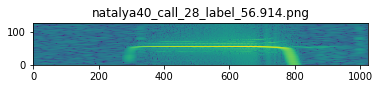

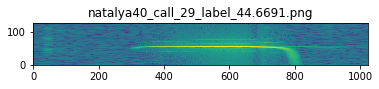

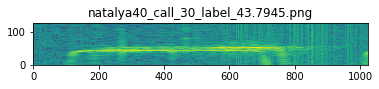


Error of -10.70
Pred: 46.50
3-Sequence of the respective images:
previous call does not exist


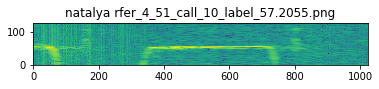

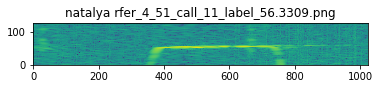


Error of 10.11
Pred: 55.95
3-Sequence of the respective images:


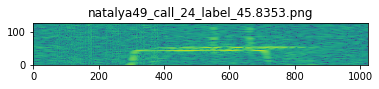

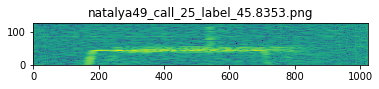

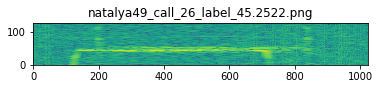


Error of 10.09
Pred: 52.43
3-Sequence of the respective images:
previous call does not exist


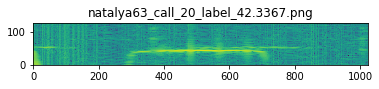

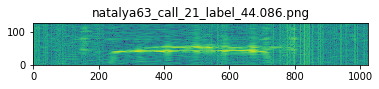


Error of 9.79
Pred: 55.33
3-Sequence of the respective images:


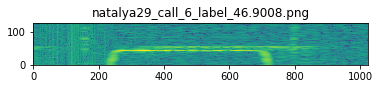

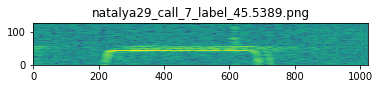

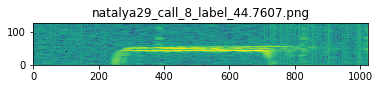


Error of 9.48
Pred: 53.86
3-Sequence of the respective images:


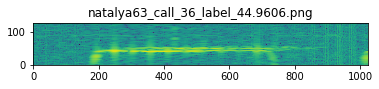

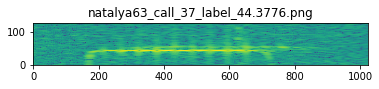

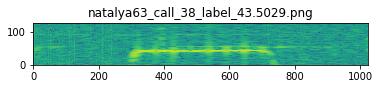


Error of 9.32
Pred: 56.61
3-Sequence of the respective images:
previous call does not exist


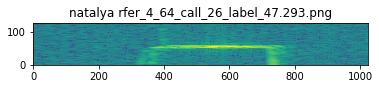

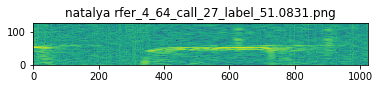


Error of -8.88
Pred: 47.17
3-Sequence of the respective images:


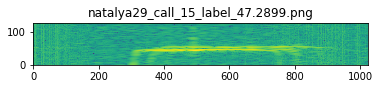

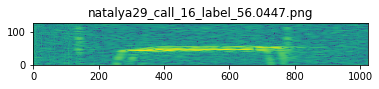

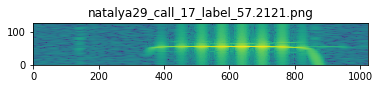


Error of 8.24
Pred: 55.53
3-Sequence of the respective images:


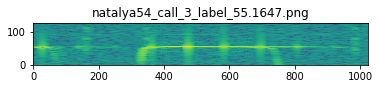

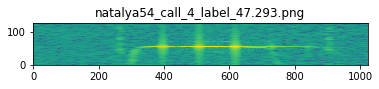

next call does not exist

Error of -7.92
Pred: 52.78
3-Sequence of the respective images:


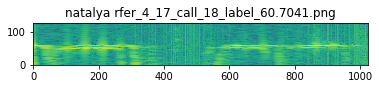

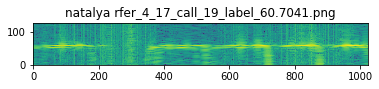

next call does not exist

Error of 7.91
Pred: 55.20
3-Sequence of the respective images:


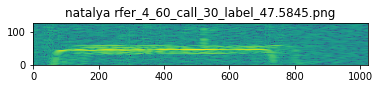

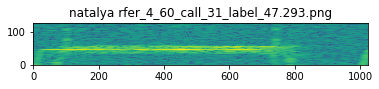

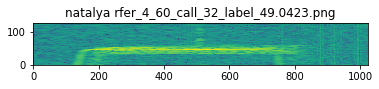


Error of -7.13
Pred: 48.33
3-Sequence of the respective images:


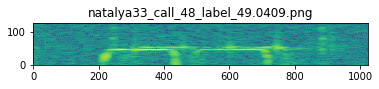

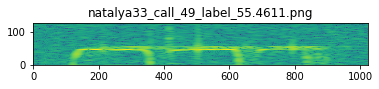

next call does not exist

Error of -6.80
Pred: 49.24
3-Sequence of the respective images:


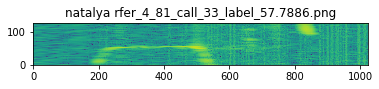

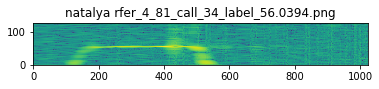

next call does not exist

Error of 6.30
Pred: 55.92
3-Sequence of the respective images:


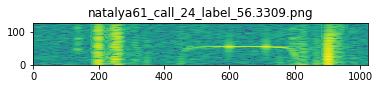

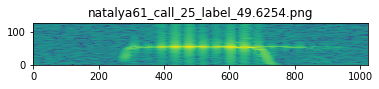

next call does not exist



In [23]:
for row in (pd.concat([trainval_df, test_df], axis=0).sort_values('abs_diff', ascending = False).head(15)).iterrows():
    print(f"Error of {row[1]['diff']:.2f}")
    print(f"Pred: {row[1]['pred']:.2f}")
    print("3-Sequence of the respective images:")
    x.seq_from_label(int(row[1]['index']), query_type = 'index')
    print()

# Explain The model behavior

In [10]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def rollout(attentions, discard_ratio, head_fusion):
    # print('test')
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 2 :]
    # print(mask.size())
    # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    mask = mask.reshape(12, 101).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
            print('Prediction=' + str(output.item()))
            # print(output)
            # print(output.size())
            # print(self.attentions[0].size())
            # print(self.discard_ratio)
            # print(self.head_fusion)
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    img = img
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

GT=55.4563
Prediction=55.61819839477539


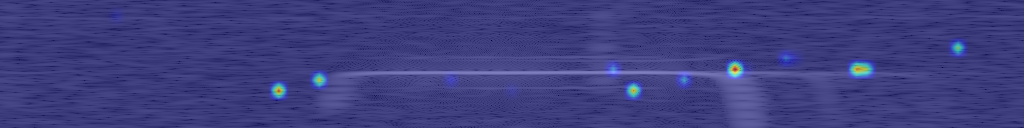

In [18]:
from google.colab.patches import cv2_imshow
# import vit_grad_roll
# from ssast.vit_grad_rollout import VITAttentionGradRollout
# from ssast.vit_rollout import VITAttentionRollout

dataloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
images, labels, index = next(iter(dataloader))
new_model.eval()

query = images.squeeze(1).to(device, dtype=torch.float)

print('GT=' + str(labels.item()))
rollout_vis = VITAttentionRollout(new_model, discard_ratio=0.999, head_fusion='mean')
small_mask = rollout_vis(query)


query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)

big_mask = cv2.resize(small_mask, (query_image.shape[1], query_image.shape[0]))
masked_image = show_mask_on_image(query_image, big_mask)
cv2_imshow(masked_image)

In [30]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()

136

In [ ]:
query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)

big_mask = cv2.resize(small_mask, (query_image.shape[1], query_image.shape[0]))
masked_image = show_mask_on_image(query_image, big_mask)
plt.imshow(masked_image)
plt.show()

(128, 1024)


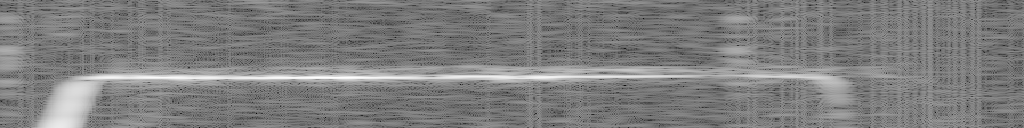

In [28]:
print(query.squeeze().cpu().numpy().shape)
cv2_imshow(query.squeeze().cpu().numpy())

In [ ]:
for name in model.named_modules():
  print (name)